# LLM Call


In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

class MyGraphState(TypedDict):
    count: int
    msg: str

# Define my node
def counter(state: MyGraphState):
    state["count"] += 1
    state["msg"] = f"Counter dunc has been called {state['count']} time(s)."
    return state

workflow =StateGraph(MyGraphState)

workflow.add_node("Node1", counter)
workflow.add_node("Node2", counter)
workflow.add_node("Node3", counter)

workflow.add_edge(START, "Node1")
workflow.add_edge("Node1", "Node2")
workflow.add_edge("Node2", "Node3")
workflow.add_edge("Node3", END)


app = workflow.compile()

In [ ]:
from IPython.display import Image, display
png = app.get_graph().draw_mermaid_png()

display(Image(png))

In [ ]:
app.invoke({"count":0, "msg":"Hello"})

In [ ]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama

model = ChatOllama(model="llama3.1")

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}


builder =StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

input = {"messages": [HumanMessage("hi!")]}
for chunk in graph.stream(input):
    print(chunk)

# #2 Chain

In [23]:
from typing import Annotated,TypedDict

from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from langgraph.graph import START,END, StateGraph

model_low_temp = ChatOllama(model="llama3.1", temperature=0.1)
model_high_temp = ChatOllama(model="llama3.1", temperature=0.7)

class State(TypedDict):
    messages : Annotated[list, add_messages]
    user_query : str
    sql_query: str
    sql_explanation: str

class Input(TypedDict):
    user_query: str
    
class Output(TypedDict):
    sql_query:str
    sql_explanation:str

generate_prompt = SystemMessage(
    """You are a helpful data analyst who generates SQL queries for user based on their questions."""
)

def generate_sql(state:State) -> State:
    user_message = HumanMessage(state["user_query"])
    messages = [generate_prompt,*state["messages"],user_message]
    res = model_low_temp.invoke(messages)
    return{
        "sql_query": res.content,
        "messages": [user_message, res]
    }

explain_prompt = SystemMessage(
    """You are a helpful data analyst whi explains SQL queries to users."""
)

def explain_sql(state:State) -> State:
    messages = [
        explain_prompt,
        *state["messages"]
    ]
    res = model_high_temp.invoke(messages)
    return{
        "sql_explanation":res.content,
        "messages": [res]

    }

In [24]:
builder = StateGraph(State, input=Input, output=Output)
builder.add_node("generate_sql", generate_sql)
builder.add_node("explain_sql", explain_sql)
builder.add_edge(START, "generate_sql")
builder.add_edge("generate_sql","explain_sql")
builder.add_edge("explain_sql", END)

graph =builder.compile()

/tmp/ipykernel_15282/1431255507.py:1: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(State, input=Input, output=Output)
/tmp/ipykernel_15282/1431255507.py:1: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(State, input=Input, output=Output)


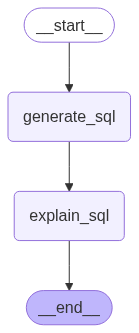

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
graph.invoke({"user_query": "What is the total sales for each product?"})

{'sql_query': 'Here\'s an SQL query that will give you the total sales for each product:\n\n```sql\nSELECT \n  product_name, \n  SUM(sales_amount) AS total_sales\nFROM \n  orders\nGROUP BY \n  product_name;\n```\n\nThis query works as follows:\n\n- `SELECT` selects the columns we want to see in our results. In this case, we\'re selecting the `product_name` and calculating the `total_sales` by summing up all sales amounts for each product.\n- `FROM orders` specifies that we\'re looking at data from the `orders` table.\n- `GROUP BY product_name` groups the rows of the result set by the `product_name`, so we can calculate the total sales for each product.\n\nNote: This assumes you have a table named "orders" with columns named "product_name" and "sales_amount". If your column names are different, you\'ll need to adjust the query accordingly.',
 'sql_explanation': ''}

# #3:Router

In [14]:
# Vectore store with filled documents
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_community.document_loaders import TextLoader
from langchain_ollama import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

embedding_model = OllamaEmbeddings(model="llama3.1:latest")

#load docs(here insurance_faq and medical_records)
medical_doc = TextLoader("./medical_records.txt").load()
insurnce_doc = TextLoader("./insurance_faq.txt").load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
medical_chunks = text_splitter.split_documents(medical_doc)
insurance_chunks = text_splitter.split_documents(insurnce_doc)
medical_records_store = InMemoryVectorStore.from_documents(documents=medical_chunks, embedding=embedding_model)
medical_records_retriever = medical_records_store.as_retriever()
insurance_faqs_store = InMemoryVectorStore.from_documents(documents=medical_chunks, embedding=embedding_model)
insurance_faqs_retriever = insurance_faqs_store.as_retriever()

/tmp/ipykernel_191751/3431508597.py:63: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder =StateGraph(State, input=Input, output=Output)
/tmp/ipykernel_191751/3431508597.py:63: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder =StateGraph(State, input=Input, output=Output)


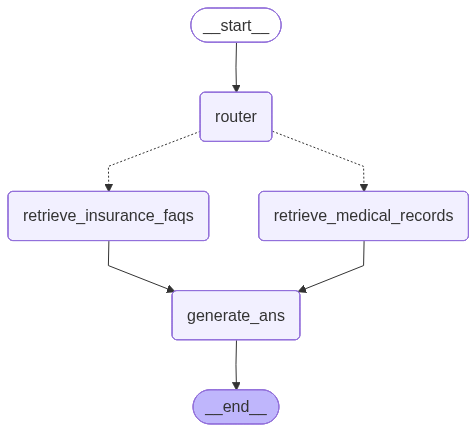

In [17]:
from langgraph.graph import START,END, StateGraph
from typing import Annotated,TypedDict, Literal
from langgraph.graph.message import add_messages
from langchain_core.documents import Document
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage,SystemMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]
    user_query: str
    domain: Literal["records", "insurance"]
    documents: list[Document]
    ans: str
class Input(TypedDict):
    user_query: str
class Output(TypedDict):
    documents: list[Document]
    ans: str

model_low_temp = ChatOllama(model="llama3.1:latest", temperature=0.1)
model_high_temp = ChatOllama(model="llama3.1:latest", temperature=0.7)

router_prompt = SystemMessage("""You need to decide which domain to route the user query to. You have two options
                              to choose from:
                              - records: contains medical records of patient, such as diagnosis, treatment, adn prescriptions.
                              - insurance: contains frequently asked questions about insurance policies, claims, and coverage.
                              Output only the domain name.""")

def router_node(state:State) -> State:
    user_message = HumanMessage(state["user_query"])
    messages = [router_prompt, *state["messages"], user_message]
    res = model_low_temp.invoke(messages)
    return {"domain": res.content, "messages": [user_message, res]}

def pick_retriever(state: State) -> Literal["retrieve_medical_records", "retrieve_insurance_faqs"]:
    if state["domain"]=="records":
        return "retrieve_medical_records"
    else:
        return "retrieve_insurance_faqs"
    
def retrieve_medical_records(state:State)-> State:
    documents = medical_records_retriever.invoke(state["user_query"])
    return {"documents": documents}

def retrieve_insurance_faqs(state:State)-> State:
    documents = insurance_faqs_retriever.invoke(state["user_query"])
    return {"documents": documents}

medical_records_prompt = SystemMessage("""You are a helpful medical chatbot who answers questions based on
                                       the patient's medical records, such as diagnosis, treatment, and prescriptions.""")
insurance_faqs_prompt = SystemMessage("""You are a helpful medical insurance chatbot who answers frequently
                                       asked questions about insurance policies, claims, and coverage.""")

def generate_ans(state:State)-> State:
    if state["domain"]=="records":
        prompt = medical_records_prompt
    else:
        prompt = insurance_faqs_prompt
    messages = [prompt, *state["messages"], HumanMessage(f"Documents: {state["documents"]}")]
    res = model_high_temp.invoke(messages)
    return {"ans": res.content, "messages": res}

builder =StateGraph(State, input=Input, output=Output)
builder.add_node("router", router_node)
builder.add_node("retrieve_medical_records", retrieve_medical_records)
builder.add_node("retrieve_insurance_faqs", retrieve_insurance_faqs)
builder.add_node("generate_ans", generate_ans)
builder.add_edge(START, "router")
builder.add_conditional_edges("router", pick_retriever)
builder.add_edge("retrieve_medical_records", "generate_ans")
builder.add_edge("retrieve_insurance_faqs", "generate_ans")
builder.add_edge("generate_ans", END)
graph = builder.compile()

from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))


In [22]:
input = {"user_query": "Who pays for most of my hospital bill, me or my insurance?"}
for c in graph.stream(input):
    print(c)

{'router': {'domain': 'insurance', 'messages': [HumanMessage(content='Who pays for most of my hospital bill, me or my insurance?', additional_kwargs={}, response_metadata={}, id='d9bd14c4-5a9b-4a1f-b5b6-2ffa44d3d74e'), AIMessage(content='insurance', additional_kwargs={}, response_metadata={'model': 'llama3.1:latest', 'created_at': '2026-02-20T17:47:38.625214584Z', 'done': True, 'done_reason': 'stop', 'total_duration': 145842227, 'load_duration': 65400863, 'prompt_eval_count': 96, 'prompt_eval_duration': 60533328, 'eval_count': 2, 'eval_duration': 17537359, 'model_name': 'llama3.1:latest'}, id='lc_run--019c7c2a-146e-7522-bb35-a29128b48702-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 96, 'output_tokens': 2, 'total_tokens': 98})]}}
{'retrieve_insurance_faqs': {'documents': [Document(id='2ed8c814-8811-4f8c-8f89-0f5965b3f2f1', metadata={'source': './medical_records.txt'}, page_content='Gender: Other\nDiagnosis: Chronic Obstructive Pulmonary Disease\nTreatment: P